In [1]:
import pandas as pd
import numpy as np

In [2]:
from permutations import kendalltau_dist
from permutations import aggregate_parity_new
from permutations import gen_groups

In [3]:
animelist = pd.read_csv("anime_data/animelist.csv")

In [4]:
print(animelist.shape)
animelist.head(5)

(109224747, 5)


,user_id,anime_id,rating,watching_status,watched_episodes
0,0,67,9,1,1
1,0,6702,7,1,4
2,0,242,10,1,4
3,0,4898,0,1,1
4,0,21,10,1,0


In [5]:
## watching status 2 == completed

In [6]:
completed = animelist[animelist.watching_status == 2].reset_index(drop=True)

In [7]:
completed.user_id.nunique()

320781

In [8]:
completed.anime_id.nunique()

16905

In [9]:
animes = pd.read_csv("anime_data/anime.csv")

In [10]:
top_anime_ids = completed.groupby("anime_id").size().sort_values(ascending=False).head(50)
top_animes = animes[animes['MAL_ID'].isin(top_anime_ids.index)]
top_animes = top_animes.set_index('MAL_ID')
top_animes = top_animes.loc[top_anime_ids.index].reset_index()

print(completed.groupby("anime_id").size().sort_values(ascending=False).head(5))
completed.groupby("anime_id").size().sort_values(ascending=False).head(50).tail(5)

anime_id
1535     202492
16498    190852
11757    180930
6547     157196
30276    156621
dtype: int64


anime_id
6746     101512
10087    100778
14741    100535
164      100289
28223     99805
dtype: int64

In [11]:
completed_filtered = completed[completed['anime_id'].isin(top_anime_ids.index)]
completed_filtered.shape

(6250720, 5)

In [12]:
completed_filtered.user_id.nunique()

310607

In [13]:
completed_filtered.drop(columns=['watching_status', 'watched_episodes']).to_csv('anime_data/watched_animes_partial.csv')

In [14]:
completed_filtered.anime_id.nunique()

50

In [15]:
completed_filtered.shape

(6250720, 5)

In [16]:
completed_filtered = pd.read_csv('anime_data/watched_animes_partial.csv')

In [17]:
completed_filtered.user_id.nunique()

310607

### Experiment

In [18]:
rating_df = pd.read_csv('anime_data/watched_animes_partial.csv')
ground_set = set(rating_df['anime_id'])

In [19]:
rating_df.user_id.nunique()

310607

In [20]:
len(ground_set)

50

In [21]:
def borda_sort(partial_lists, ground_set):
    n_total = len(ground_set)
    scores = {elem: 0 for elem in ground_set}  # Initialize scores for all elements
    
    for l in partial_lists:
        # Compute scores for ranked elements
        for idx, elem in enumerate(reversed(l)):
            scores[elem] += idx
        
        # Compute scores for unranked elements
        ranked_elements = set(l)
        unranked_elements = ground_set - ranked_elements
        
        if unranked_elements:  # Only process if there are unranked elements
            n_ranked = len(l)
            
            # Calculate excess score
            total_score_full = n_total * (n_total - 1) / 2  # Sum of 0 to n_total-1
            total_score_used = n_ranked * (n_ranked - 1) / 2  # Sum of 0 to n_ranked-1
            excess_score = total_score_full - total_score_used
            
            # Distribute excess score equally
            score_per_unranked = excess_score / len(unranked_elements)
            for elem in unranked_elements:
                scores[elem] += score_per_unranked
    
    # Sort elements by their scores in descending order
    return sorted(scores.keys(), key=lambda elem: scores[elem], reverse=True)

In [22]:
import numpy as np
from scipy.optimize import linear_sum_assignment

def scaled_footrule_optimal(partial_lists, ground_set):
    """
    Implements the Scaled Footrule Optimal (SFO) aggregation for partial permutations.
    
    This algorithm creates a bipartite graph between elements and positions,
    with weights representing the scaled footrule distance. It then finds the
    minimum cost perfect matching to determine the optimal aggregation.
    
    Args:
        partial_lists: List of partial permutations (each permutation is a list)
        
    Returns:
        A permutation that minimizes the scaled footrule distance
    """
    
    # Convert elements to a list to ensure consistent ordering
    elements = list(ground_set)
    n = len(elements)
    
    # Create a mapping from elements to indices for easier reference
    element_to_idx = {elem: idx for idx, elem in enumerate(elements)}
    
    # Initialize the cost matrix for the bipartite matching
    # Rows represent elements, columns represent positions
    cost_matrix = np.zeros((n, n))
    
    # Calculate weights for each element-position pair
    for element_idx, element in enumerate(elements):
        for position in range(n):
            # position+1 because positions are 1-indexed
            scaled_position = (position + 1) / n
            
            # Calculate the scaled footrule distance from this element to this position
            total_distance = 0
            
            for ranking in partial_lists:
                ranking_length = len(ranking)
                
                if element in ranking:
                    # Find the position of the element in this ranking (0-indexed)
                    element_pos = ranking.index(element)
                    # Convert to 1-indexed and scale
                    scaled_element_pos = (element_pos + 1) / ranking_length
                    
                    # Add the absolute difference to the total distance
                    total_distance += abs(scaled_element_pos - scaled_position)
                # If element is not in the ranking, it doesn't contribute to the distance
            
            # Set the cost for this element-position pair
            cost_matrix[element_idx, position] = total_distance
    
    # Solve the minimum cost assignment problem using the Hungarian algorithm
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    
    # Create the final permutation based on the optimal assignment
    # The result is a list of (element, position) pairs
    assignment = [(elements[row], col + 1) for row, col in zip(row_indices, col_indices)]
    
    # Sort by position (second element of the tuple)
    assignment.sort(key=lambda x: x[1])
    
    # Extract just the elements in the optimal order
    optimal_permutation = [elem for elem, _ in assignment]
    
    return optimal_permutation

In [23]:

# # Transform the DataFrame into rankings
# rankings = transform_df_to_rankings(rating_df)
# print(f"Transformed rating_df into {len(rankings)} user rankings")
# print(f"First few rankings (examples): {rankings[:3]}")

# # Apply your ranking aggregation methods
# print("\nApplying ranking aggregation methods...")

# # 1. Borda Count
# borda_result = borda_sort(rankings)
# print(f"\nBorda ranking:\n{borda_result}")

# # 2. Markov Chain methods
# print("\nApplying Markov Chain methods...")
# mc1_result = markov_chain_rank_aggregation(rankings, method='MC1')
# print(f"MC1 ranking:\n{mc1_result}")

# mc2_result = markov_chain_rank_aggregation(rankings, method='MC2')  
# print(f"MC2 ranking:\n{mc2_result}")

# mc3_result = markov_chain_rank_aggregation(rankings, method='MC3')
# print(f"MC3 ranking:\n{mc3_result}")

# # 3. Pick-a-Perm
# print("\nApplying Pick-a-Perm method...")
# pickaperm_result = pick_a_perm(rankings, num_samples=1)
# print(f"Pick-a-Perm ranking:\n{pickaperm_result}")
# all_set_results = [borda_result, mc1_result, mc2_result, mc3_result, pickaperm_result]

# print([compute_kendall_tau_cost(res, rankings) for res in all_set_results])


In [24]:
import numpy as np
import random

def markov_chain_rank_aggregation(rankings, all_items, method='MC3', iterations=1000, convergence_threshold=1e-6):
    """
    Markov Chain rank aggregation using different MC methods, properly handling partial lists.
    
    Args:
        rankings: List of rankings, where each ranking is a list of items sorted by preference
                 (first item is most preferred, last item is least preferred)
        method: Which Markov Chain method to use ('MC1', 'MC2', 'MC3', or 'MC4')
        iterations: Maximum number of power iterations for finding stationary distribution
        convergence_threshold: Threshold for convergence in power iteration
    
    Returns:
        Aggregated ranking as a list of items
    """
    # Create item to index mapping
    item_to_idx = {item: i for i, item in enumerate(all_items)}
    idx_to_item = {i: item for i, item in enumerate(all_items)}
    n = len(all_items)
    
    # Initialize transition matrix
    P = np.zeros((n, n))
    
    # Find items that appear in each ranking and their positions
    item_positions = []
    for ranking in rankings:
        positions = {item: pos for pos, item in enumerate(ranking)}
        item_positions.append(positions)
    
    # Populate transition matrix based on the specified method
    if method == 'MC1':
        # For each item P
        for p_idx, p_item in enumerate(all_items):
            # Count transitions to items ranked higher or equal in each list
            transitions = []
            
            for i, positions in enumerate(item_positions):
                if p_item in positions:  # Only consider lists that ranked P
                    p_pos = positions[p_item]
                    # Find items ranked higher or equal to P in this list
                    for item, pos in positions.items():
                        if pos <= p_pos:  # Higher or equal rank (smaller position number)
                            transitions.append(item_to_idx[item])
            
            # If there are transitions, set probability uniformly
            if transitions:
                for idx in transitions:
                    P[p_idx, idx] += 1
                # Normalize to get uniform probability
                P[p_idx] = P[p_idx] / len(transitions)
            else:
                # If no transitions, uniform probability to all items
                P[p_idx] = 1.0 / n
    
    elif method == 'MC2':
        # For each item P
        for p_idx, p_item in enumerate(all_items):
            # Count transitions to items ranked higher or equal in each list
            lists_with_p = [i for i, positions in enumerate(item_positions) if p_item in positions]
            
            if lists_with_p:  # Only if P appears in at least one list
                # For each list that ranked P
                for list_idx in lists_with_p:
                    positions = item_positions[list_idx]
                    p_pos = positions[p_item]
                    
                    # Find items ranked higher or equal to P in this list
                    higher_or_equal = [item_to_idx[item] for item, pos in positions.items() 
                                      if pos <= p_pos]
                    
                    # Add uniform probability for this list
                    if higher_or_equal:
                        for idx in higher_or_equal:
                            P[p_idx, idx] += 1.0 / len(higher_or_equal)
                
                # Normalize by number of lists that ranked P
                P[p_idx] = P[p_idx] / len(lists_with_p)
            else:
                # If P doesn't appear in any list, uniform probability to all items
                P[p_idx] = 1.0 / n
    
    elif method == 'MC3':
        # For each item P
        for p_idx, p_item in enumerate(all_items):
            # Count transitions for each list that ranked P
            lists_with_p = [i for i, positions in enumerate(item_positions) if p_item in positions]
            stay_prob = 0.0
            
            if lists_with_p:  # Only if P appears in at least one list
                # For each list that ranked P
                for list_idx in lists_with_p:
                    positions = item_positions[list_idx]
                    p_pos = positions[p_item]
                    
                    # Count items ranked by this list
                    num_items_in_list = len(positions)
                    
                    # For each item Q in this list
                    for q_item, q_pos in positions.items():
                        q_idx = item_to_idx[q_item]
                        
                        # If Q is ranked higher than P, go to Q
                        if q_pos < p_pos:
                            P[p_idx, q_idx] += 1.0 / num_items_in_list
                        # If Q is P or ranked lower, stay in P
                        else:
                            stay_prob += 1.0 / num_items_in_list
                
                # Add self-loop probability
                P[p_idx, p_idx] += stay_prob
                
                # Normalize by number of lists that ranked P
                P[p_idx] = P[p_idx] / len(lists_with_p)
            else:
                # If P doesn't appear in any list, uniform probability to all items
                P[p_idx] = 1.0 / n
    
    elif method == 'MC4':
        # For each item P
        for p_idx, p_item in enumerate(all_items):
            # For each item Q
            for q_idx, q_item in enumerate(all_items):
                if p_idx != q_idx:  # Don't compare item to itself
                    # Count lists where both P and Q appear
                    lists_with_both = []
                    for i, positions in enumerate(item_positions):
                        if p_item in positions and q_item in positions:
                            lists_with_both.append(i)
                    
                    if lists_with_both:
                        # Count lists where Q is ranked higher than P
                        q_wins = 0
                        for list_idx in lists_with_both:
                            positions = item_positions[list_idx]
                            if positions[q_item] < positions[p_item]:
                                q_wins += 1
                        
                        # If Q wins majority of comparisons, go to Q
                        if q_wins > len(lists_with_both) / 2:
                            P[p_idx, q_idx] += 1
            
            # Normalize row to get probability distribution
            row_sum = P[p_idx].sum()
            if row_sum > 0:
                P[p_idx] = P[p_idx] / row_sum
            else:
                # If no transitions, uniform probability to all items
                P[p_idx] = 1.0 / n
    
    else:
        raise ValueError(f"Unknown method: {method}. Choose from 'MC1', 'MC2', 'MC3', or 'MC4'.")
    
    # Ensure the matrix is valid (in rare cases, normalization issues)
    for i in range(n):
        if np.isclose(P[i].sum(), 0):
            P[i] = 1.0 / n
        else:
            P[i] = P[i] / P[i].sum()
    
    # Find stationary distribution using power iteration
    # Start with uniform distribution
    stationary = np.ones(n) / n
    
    for _ in range(iterations):
        prev_stationary = stationary.copy()
        stationary = stationary @ P
        
        # Check for convergence
        if np.allclose(stationary, prev_stationary, rtol=convergence_threshold):
            break
    
    # Sort items by stationary probability (descending)
    sorted_indices = np.argsort(-stationary)
    
    # Convert back to original items
    return [idx_to_item[idx] for idx in sorted_indices]


In [25]:

    
def compute_kendall_tau_cost(ranking, all_rankings, sample_size = None):
    """
    Compute the average Kendall tau distance between a ranking and a sampled subset of rankings.

    Args:
        ranking: A candidate consensus ranking
        all_rankings: A set of rankings (list of lists or numpy array of lists)
        sample_size: Number of rankings to sample for cost estimation (default: 2000)

    Returns:
        The average Kendall tau distance over the sampled rankings
    """
    # Adjust sample size if it exceeds the size of all_rankings

    # Randomly sample indices without replacement
    if sample_size is not None and sample_size < len(all_rankings):
        sampled_indices = np.random.choice(len(all_rankings), sample_size, replace=True)
        sampled_rankings = [all_rankings[i] for i in sampled_indices]
    else:
        sampled_rankings = all_rankings

    # Compute total distance on sampled rankings
    total_distance = 0
    for rank in sampled_rankings:
        partial_elements = set(rank)
        induced_ranking = [elem for elem in ranking if elem in partial_elements]
        total_distance += kendalltau_dist(induced_ranking, rank)

    # Return average distance
    return total_distance / len(sampled_rankings)



In [26]:

# def pick_a_perm(lists, num_samples=100):
#     """
#     Pick-a-Perm method: Randomly sample rankings from input lists and 
#     pick the one with minimum Kendall tau cost.
    
#     Args:
#         lists: List of rankings to aggregate
#         num_samples: Number of rankings to sample (default: 100)
    
#     Returns:
#         The ranking from the sample with minimum total Kendall tau distance
#     """
#     import random
#     import numpy as np
    
#     # Ensure we don't try to sample more rankings than exist
#     num_samples = min(num_samples, len(lists))
    
#     # Sample indices with replacement if num_samples <= len(lists)
#     if num_samples < len(lists):
#         sampled_indices = random.sample(range(len(lists)), num_samples)
#     else:
#         sampled_indices = range(len(lists))  # Use all lists
    
#     sampled_rankings = [lists[i] for i in sampled_indices]
    
#     # Find permutation with minimum cost
#     best_ranking = None
#     min_cost = float('inf')
    
#     for ranking in sampled_rankings:
#         # Compute cost against all input rankings
#         cost = compute_kendall_tau_cost(ranking, lists)
        
#         if cost < min_cost:
#             min_cost = cost
#             best_ranking = ranking
    
#     return best_ranking

In [27]:
def transform_df_to_rankings(df):
    """
    Transform a DataFrame with columns ['user_id', 'anime_id', 'rating']
    to a list of lists, where each inner list contains anime_ids ranked by rating for a user (is a partial list).
    Breaks ties arbitrarily by adding small random noise to ratings.
    
    Args:
        df: DataFrame with columns ['user_id', 'anime_id', 'rating']
        
    Returns:
        List of lists, where each inner list is a ranking of anime_ids for a user
    """
    # Create a copy to avoid modifying the original DataFrame
    df_copy = df.copy()
    
    # Add small random noise to break ties arbitrarily
    np.random.seed(42)  # for reproducibility
    df_copy['rating_with_noise'] = df_copy['rating'] + np.random.uniform(-0.5, 0.5, size=len(df_copy))
    
    # Group by user_id and create ordered lists of anime_ids
    user_rankings = []
    
    for user_id, group in df_copy.groupby('user_id'):
        # Sort by rating_with_noise in descending order (highest rating first)
        sorted_group = group.sort_values('rating_with_noise', ascending=False)
        
        # Get the ordered list of anime_ids
        anime_ranking = sorted_group['anime_id'].tolist()
        
        # Add this ranking to our list
        user_rankings.append(anime_ranking)
    
    return user_rankings

In [28]:

# Transform the DataFrame into rankings
rankings = transform_df_to_rankings(rating_df)
# print(f"Transformed rating_df into {len(rankings)} user rankings")
# print(f"First few rankings (examples): {rankings[:3]}")

# # Apply your ranking aggregation methods
# print("\nApplying ranking aggregation methods...")

# # 1. Borda Count
# borda_result = borda_sort(rankings, ground_set)
# print(f"\nBorda ranking:\n{borda_result}")

# # 2. footnote rule 
# sfo_result = scaled_footrule_optimal(rankings, ground_set)
# # 2. Markov Chain methods
# print("\nApplying Markov Chain methods...")
# mc1_result = markov_chain_rank_aggregation(rankings, ground_set, method='MC1')
# print(f"MC1 ranking:\n{mc1_result}")

# mc2_result = markov_chain_rank_aggregation(rankings, ground_set, method='MC2')  
# print(f"MC2 ranking:\n{mc2_result}")

# mc3_result = markov_chain_rank_aggregation(rankings, ground_set, method='MC3')
# print(f"MC3 ranking:\n{mc3_result}")

# mc4_result = markov_chain_rank_aggregation(rankings, ground_set, method='MC4')
# print(f"MC3 ranking:\n{mc3_result}")

# # # 3. Pick-a-Perm
# # print("\nApplying Pick-a-Perm method...")
# # pickaperm_result = pick_a_perm(rankings, num_samples=1)
# # print(f"Pick-a-Perm ranking:\n{pickaperm_result}")
# all_set_results = [borda_result, mc1_result, mc2_result, mc3_result, mc4_result, sfo_result]

# print([compute_kendall_tau_cost(res, rankings) for res in all_set_results])


In [29]:
def convert_ids_to_names(sfo_result, animes):
    """
    Convert a list of MAL_IDs to their corresponding anime names
    
    Args:
        sfo_result: List of MAL_IDs from the SFO algorithm
        id_to_name: Dictionary mapping from MAL_ID to anime name
        default_text: Text to use for IDs not found in the dictionary (default is "Unknown Anime")
    
    Returns:
        List of anime names in the same order as sfo_result
    """
    id_to_name = dict(zip(animes['MAL_ID'], animes['Name']))
    # Convert each ID to its corresponding name
    named_result = [id_to_name.get(mal_id) for mal_id in sfo_result]
    return named_result

In [30]:
import numpy as np
import random

def sample_ground_set_and_rankings(ground_set, rankings, sample_items=20, sample_size=1000):
    ground_set_list = list(ground_set)
    sampled_ground_set = random.sample(ground_set_list, sample_items)
    sampled_ground_set = set(sampled_ground_set)
    sampled_items_set = set(sampled_ground_set)
    sample_indices = np.random.choice(len(rankings), size=sample_size, replace=False)
    sampled_rankings = []
    for idx in sample_indices:
        original_ranking = rankings[idx]
        projected_ranking = [item for item in original_ranking if item in sampled_items_set]
        sampled_rankings.append(projected_ranking)
    
    return sampled_ground_set, sampled_rankings

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time

def create_uniform_coreset(all_rankings, coreset_size):
    """
    Create a uniform random coreset of rankings by sampling with replacement.
    """
    indices = np.random.choice(len(all_rankings), size=coreset_size, replace=True)
    uniform_coreset = [all_rankings[i] for i in indices]
    return uniform_coreset

    
def run_coreset_experiment(rankings, ground_set, num_repeats=20, coreset_sizes = None):
    """
    Run experiment comparing different ranking methods across coreset sizes.
    """

    # Methods to compare
    methods = {
        'MC1': lambda r: markov_chain_rank_aggregation(r, ground_set, method='MC1'),
        'MC2': lambda r: markov_chain_rank_aggregation(r, ground_set, method='MC2'),
        'MC3': lambda r: markov_chain_rank_aggregation(r, ground_set, method='MC3'),
        'MC4': lambda r: markov_chain_rank_aggregation(r, ground_set, method='MC4'),
        'SFO': lambda r: scaled_footrule_optimal(r, ground_set),
        'Borda': lambda r: borda_sort(r, ground_set)
    }
    
    # Define coreset sizes
    if coreset_sizes is None:
        coreset_sizes = np.arange(150, 1050, 50) #50
        print("coreset_sizes", len(coreset_sizes))
    full_results = {}
    full_costs = {}
    full_times = {}  # Store execution times for full dataset
    
    for method_name, method_func in methods.items():
        try:
            start_time = time.time()
            full_results[method_name] = method_func(rankings)
            print("running worked", full_results[method_name])
            end_time = time.time()
            execution_time = end_time - start_time
            
            full_times[method_name] = execution_time
            full_costs[method_name] = compute_kendall_tau_cost(full_results[method_name], rankings, sample_size=1_000)
            
            print(f"Full dataset {method_name} cost: {full_costs[method_name]:.2f}, time: {execution_time:.2f} seconds")
        except Exception as e:
            print(f"Error running {method_name} on full dataset: {e}")
            full_costs[method_name] = np.nan
            full_times[method_name] = np.nan

    print("done with full")
    print(full_costs)
    # Storage for results
    results = {method: [] for method in methods}
    std_devs = {method: [] for method in methods}
    
    # Storage for timing information on coresets
    coreset_times = {method: [] for method in methods}
    
    # Run experiments for each coreset size
    print("\nRunning coreset experiments...")
    for size in tqdm(coreset_sizes, desc="Testing coreset sizes"):
        method_costs = {method: [] for method in methods}
        method_times = {method: [] for method in methods}
        
        # Repeat multiple times for stability
        for _ in range(num_repeats):
            # Create uniform coreset
            coreset = create_uniform_coreset(rankings, size)
            
            # Apply each method
            for method_name, method_func in methods.items():
                try:
                    # Measure execution time for this method on the coreset
                    start_time = time.time()
                    agg_ranking = method_func(coreset)
                    end_time = time.time()
                    execution_time = end_time - start_time
                    
                    # Store the execution time
                    method_times[method_name].append(execution_time)
                    
                    # Compute cost against full rankings
                    cost = compute_kendall_tau_cost(agg_ranking, rankings, sample_size=1_000)
                    method_costs[method_name].append(cost)
                except Exception as e:
                    print(f"Error with {method_name} on size {size}: {e}")
        
        # Compute average costs, standard deviations, and execution times
        for method in methods:
            if method_costs[method]:
                # Cost statistics
                results[method].append(np.mean(method_costs[method]))
                std_devs[method].append(np.std(method_costs[method]))
                
                # Time statistics
                coreset_times[method].append(np.mean(method_times[method]))
            else:
                results[method].append(np.nan)
                std_devs[method].append(np.nan)
                coreset_times[method].append(np.nan)
    
    # Print summary of timing information
    print("\n===== Time Comparison Summary =====")
    print("Method\tFull Dataset\tMax Coreset Time")
    for method in methods:
        max_coreset_time = max([t for t in coreset_times[method] if not np.isnan(t)], default=np.nan)
        print(f"{method}\t{full_times.get(method, np.nan):.4f}s\t{max_coreset_time:.4f}s")
    
    return results, full_costs, std_devs, coreset_sizes

    
def plot_results(coreset_sizes, results, full_costs, std_devs, num_repeats=20):
    """
    Parameters:
    -----------
    coreset_sizes : array-like
        The sizes of coresets used in the experiment
    results : dict
        Dictionary mapping method names to lists of average costs
    full_costs : dict
        Dictionary mapping method names to costs on the full dataset
    std_devs : dict
        Dictionary mapping method names to lists of standard deviations
    """
    plt.figure(figsize=(10, 6))
    
    # Set seaborn style for better aesthetics
    sns.set_theme(style="whitegrid")
    
    # Scientific color palette - colorblind friendly and distinguishable
    colors = {
        'MC1': '#0173B2',    # Blue
        'MC2': '#DE8F05',    # Orange
        'MC3': '#029E73',    # Green
        'MC4': '#CC78BC',    # Purple
        'SFO': '#D55E00',    # Red
        'Borda': '#CA9161'   # Brown
    }
    
    # Use same line style for all methods
    linestyles = {
        'MC1': '-',
        'MC2': '-',
        'MC3': '-',
        'MC4': '-',
        'SFO': '-',
        'Borda': '-'
    }
    
    # Get a list of all methods in the results
    all_methods = list(results.keys())
    for method in all_methods:
        std_devs[method] = [x/ np.sqrt(num_repeats) for x in std_devs[method]]
    
    
    # Plot coreset results with smooth lines and standard deviation bands
    for method in all_methods:
        # Skip if this method has no data
        if len(results[method]) == 0 or np.all(np.isnan(results[method])):
            continue
            
        # Get color for this method (default to a backup color if not in the palette)
        color = colors.get(method, '#333333')  # Default to dark gray
        style = linestyles.get(method, '-')    # Default to solid line
        
        # Convert to numpy arrays for easier handling
        costs_array = np.array(results[method])
        stds_array = np.array(std_devs[method])
        
        # Plot the main line
        plt.plot(coreset_sizes, costs_array, style, 
                color=color, 
                label=f"{method} (Coreset)", 
                linewidth=2.5,
                zorder=10)  # Make sure lines are on top of the shaded regions
        
        # Add standard deviation as a shaded area
        plt.fill_between(coreset_sizes, 
                         costs_array - stds_array,
                         costs_array + stds_array,
                         color=color, 
                         alpha=0.15,
                         zorder=5)
    
    # Add horizontal lines for full dataset results
    for method in all_methods:
        if method in full_costs and not np.isnan(full_costs[method]):
            color = colors.get(method, '#333333')  # Default to dark gray
            plt.axhline(y=full_costs[method], 
                      linestyle='--', 
                      color=color, 
                      label=f"{method} (Full Dataset)", 
                      linewidth=2,
                      zorder=11)  # Make sure these lines are on top
    
    # Improved styling
    plt.xlabel('Coreset Size', fontsize=14)
    plt.ylabel('Kendall Tau Cost', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Use log scale for y-axis to better visualize differences
    # plt.yscale('log')
    
    # Determine number of columns for legend based on number of methods
    ncol = 2
    if len(all_methods) > 6:
        ncol = 3
    
    # Add a multi-column legend in the upper left corner
    plt.legend(fontsize=11, frameon=True, framealpha=0.95,
              edgecolor='gray', fancybox=False,
              loc='upper left',  # Position in upper left
              bbox_to_anchor=(0.01, 0.99),  # Fine-tune position
              ncol=ncol)  # Multiple columns for more compact width
    
    # Set x-axis ticks
    if len(coreset_sizes) > 4:
        plt.xticks(coreset_sizes[::2], fontsize=12)
    else:
        plt.xticks(coreset_sizes, fontsize=12)
    plt.yticks(fontsize=12)
    
    # Make the spines visible but subtle
    for spine in plt.gca().spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.5)
        spine.set_color('gray')
    
    plt.tight_layout()
    plt.savefig('ranking_methods_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return plt.gcf()  # Return the figure for further customization if needed

In [32]:
def plot_results(coreset_sizes, results, full_costs, std_devs=None, num_repeats=20):
    """
    Parameters:
    -----------
    coreset_sizes : array-like
        The sizes of coresets used in the experiment
    results : dict
        Dictionary mapping method names to lists of average costs
    full_costs : dict
        Dictionary mapping method names to costs on the full dataset
    std_devs : dict, optional
        Dictionary mapping method names to lists of standard deviations.
        If None, no error bands will be plotted.
    num_repeats : int, default=20
        Number of experiment repetitions (used for standard error calculation)
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    from scipy import stats
    
    plt.figure(figsize=(10, 6))
    
    # Set seaborn style for better aesthetics
    sns.set_theme(style="whitegrid")
    
    # Scientific color palette - colorblind friendly and distinguishable
    colors = {
        'MC1': '#0173B2',    # Blue
        'MC2': '#DE8F05',    # Orange
        'MC3': '#029E73',    # Green
        'MC4': '#CC78BC',    # Purple
        'SFO': '#D55E00',    # Red
        'Borda': '#CA9161'   # Brown
    }
    
    # Use same line style for all methods
    linestyles = {
        'MC1': '-',
        'MC2': '-',
        'MC3': '-',
        'MC4': '-',
        'SFO': '-',
        'Borda': '-'
    }
    
    # Get a list of all methods in the results
    all_methods = list(results.keys())
    
    # Create a copy of std_devs to avoid modifying the original (if provided)
    std_devs_adjusted = {}
    if std_devs is not None:
        for method in all_methods:
            if method in std_devs:
                std_devs_adjusted[method] = [x / np.sqrt(num_repeats) for x in std_devs[method]]
    
    # Calculate relative errors for each method
    relative_errors = {}
    relative_stds = {}
    
    for method in all_methods:
        # Skip if this method has no data or no full cost
        if len(results[method]) == 0 or np.all(np.isnan(results[method])) or method not in full_costs:
            continue
        
        # Get the full dataset cost for this method
        full_cost = full_costs[method]
        
        # Skip if full cost is 0 (to avoid division by zero)
        if full_cost == 0:
            continue
        
        # Calculate relative error as percentage: ((coreset_cost - full_cost) / full_cost) * 100
        relative_errors[method] = [((cost - full_cost) / full_cost) * 100 for cost in results[method]]
        
        # Adjust standard deviations if provided
        if std_devs is not None and method in std_devs_adjusted:
            # Scale standard deviations by the same denominator and convert to percentage
            relative_stds[method] = [(std / full_cost) * 100 for std in std_devs_adjusted[method]]
    
    # Plot relative errors with regression lines and data points
    for method in relative_errors:
        # Get color for this method (default to a backup color if not in the palette)
        color = colors.get(method, '#333333')  # Default to dark gray
        style = linestyles.get(method, '-')    # Default to solid line
        
        # Convert to numpy arrays for easier handling
        rel_errors_array = np.array(relative_errors[method])
        
        # Calculate linear regression line if we have at least 2 points
        if len(coreset_sizes) >= 2:
            # Create X range for regression line (extend slightly beyond the data)
            x_range = np.linspace(min(coreset_sizes) * 0.95, max(coreset_sizes) * 1.05, 100)
            
            # Linear regression (1st degree polynomial)
            slope, intercept, r_value, p_value, std_err = stats.linregress(coreset_sizes, rel_errors_array)
            line = slope * x_range + intercept
            
            # Plot the regression line
            plt.plot(x_range, line, style, 
                    color=color, 
                    label=f"{method}", 
                    linewidth=2.5,
                    zorder=10)
                
            # Add standard deviation as a shaded area around the original points if provided
            if std_devs is not None and method in relative_stds:
                rel_stds_array = np.array(relative_stds[method])
                plt.fill_between(coreset_sizes, 
                                rel_errors_array - rel_stds_array,
                                rel_errors_array + rel_stds_array,
                                color=color, 
                                alpha=0.15,
                                zorder=5)
        else:
            # Just plot a single point if only one data point
            plt.plot(coreset_sizes, rel_errors_array, style, 
                    color=color, 
                    label=f"{method}", 
                    linewidth=2.5,
                    zorder=10)
            
            # Add standard deviation as a shaded area if provided
            if std_devs is not None and method in relative_stds:
                rel_stds_array = np.array(relative_stds[method])
                plt.fill_between(coreset_sizes, 
                                rel_errors_array - rel_stds_array,
                                rel_errors_array + rel_stds_array,
                                color=color, 
                                alpha=0.15,
                                zorder=5)
        
        # Add markers for the actual data points
        plt.scatter(coreset_sizes, rel_errors_array, 
                   color=color, 
                   s=25,  # Size of dots
                    alpha=0.5,
                   zorder=15,  # Make sure dots are on top
                   edgecolor='white',  # White edge makes dots stand out
                   linewidth=1)
    
    # Add a horizontal line at y=0 (representing no difference from full dataset)
    plt.axhline(y=0, linestyle='-', color='black', linewidth=1, alpha=0.5, zorder=5)
    
    # Improved styling
    plt.xlabel('Coreset Size', fontsize=14)
    plt.ylabel('Relative Error (%)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Determine number of columns for legend based on number of methods
    ncol = 2
    if len(all_methods) > 6:
        ncol = 3
    
    # Add a multi-column legend in the upper left corner
    plt.legend(fontsize=11, frameon=True, framealpha=0.95,
              edgecolor='gray', fancybox=False,
              loc='lower right',  # Position in upper left
              bbox_to_anchor=(1, 0),  # Fine-tune position
              ncol=ncol)  # Multiple columns for more compact width
    
    # Set x-axis ticks
    if len(coreset_sizes) > 4:
        plt.xticks(coreset_sizes[::2], fontsize=12)
    else:
        plt.xticks(coreset_sizes, fontsize=12)
    plt.yticks(fontsize=12)
    
    # Make the spines visible but subtle
    for spine in plt.gca().spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.5)
        spine.set_color('gray')
    
    plt.tight_layout()
    plt.savefig('figures/ranking_methods_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return plt.gcf()  # Return the figure for further customization if needed

In [33]:
rankings = transform_df_to_rankings(rating_df)
print(f"Transformed rating_df into {len(rankings)} user rankings")


Transformed rating_df into 310607 user rankings


In [34]:
sampled_ground_set, sampled_rankings = sample_ground_set_and_rankings(ground_set, rankings)

In [37]:

# Run the experiment
# results, full_costs, std_devs, coreset_sizes = run_coreset_experiment(sampled_rankings, sampled_ground_set, num_repeats=2)
results, full_costs, std_devs, coreset_sizes = run_coreset_experiment(rankings, ground_set, num_repeats=20)


# plot_results(coreset_sizes, results, full_costs, std_devs)

coreset_sizes 18
running worked [5114, 1535, 32281, 2904, 30276, 23273, 6547, 31240, 9989, 25777, 5081, 10087, 9756, 30831, 10620, 20, 14813, 11111, 849, 22199]
Full dataset MC1 cost: 20.81, time: 0.04 seconds
running worked [5114, 1535, 32281, 2904, 30276, 23273, 9989, 6547, 25777, 5081, 31240, 9756, 10087, 20, 30831, 10620, 849, 14813, 11111, 22199]
Full dataset MC2 cost: 20.58, time: 0.02 seconds
running worked [5114, 1535, 32281, 2904, 30276, 23273, 9989, 5081, 25777, 6547, 31240, 9756, 10087, 30831, 20, 10620, 849, 14813, 11111, 22199]
Full dataset MC3 cost: 20.48, time: 0.02 seconds
running worked [5114, 2904, 32281, 23273, 1535, 30276, 9756, 10087, 5081, 31240, 25777, 9989, 6547, 30831, 14813, 849, 20, 10620, 11111, 22199]
Full dataset MC4 cost: 20.76, time: 0.03 seconds
running worked [23273, 9756, 5114, 2904, 32281, 5081, 10087, 30276, 31240, 1535, 9989, 25777, 6547, 30831, 20, 14813, 10620, 11111, 849, 22199]
Full dataset SFO cost: 20.40, time: 0.06 seconds
running worked [97

Testing coreset sizes: 100%|████████████████████| 18/18 [00:11<00:00,  1.58it/s]


===== Time Comparison Summary =====
Method	Full Dataset	Max Coreset Time
MC1	0.0387s	0.0134s
MC2	0.0174s	0.0163s
MC3	0.0153s	0.0156s
MC4	0.0310s	0.0417s
SFO	0.0601s	0.0594s
Borda	0.0023s	0.0023s


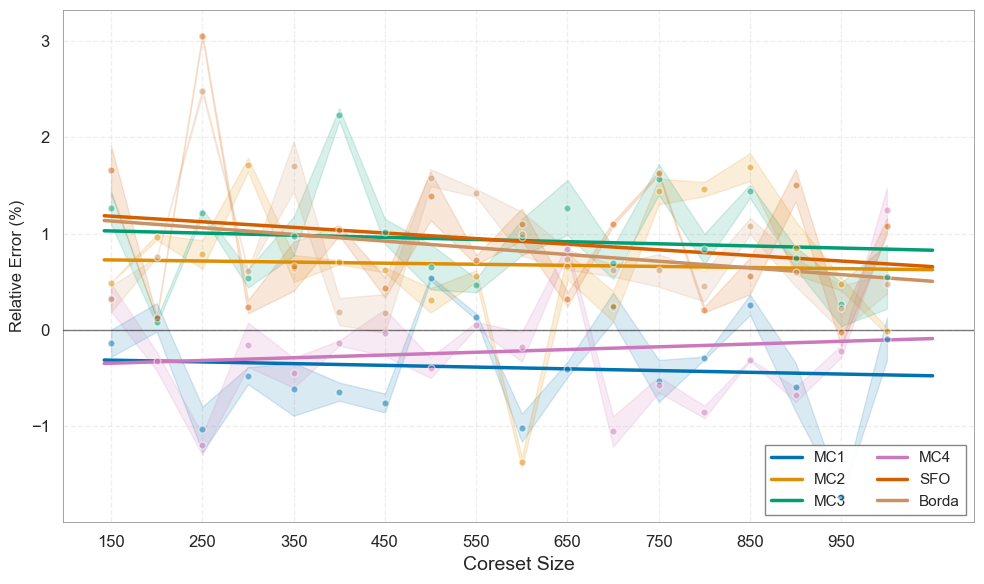

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [38]:
plot_results(coreset_sizes, results, full_costs, std_devs)